In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from scipy import stats
import os
from io import BytesIO
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import InformerConfig, InformerModel 
from transformers.models.informer.modeling_informer import InformerEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import stats
import json 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
from util.parallelzipfile import ParallelZipFile as ZipFile
import tarfile
from pathlib import Path
from core.multimodal.dataset import collate_fn, ASASSNVarStarDataset
from core.multimodal.dataset2 import VGDataset
from core.multimodal.trainer import ClassificationTrainer
from functools import partial
import matplotlib.pyplot as plt
from models.Informer import Informer
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from filelock import FileLock
from torch.utils.data import Dataset
import zipfile

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [328]:
"""
Combine both bands to create 1 lcs dataset. Important: each object (based on EDR3_source_id and edr3_source_id) should be only in train, val or test split!
Remove duplicates, filter classes, limit samples, split
Dataset should preprocess lcs: fold and then sort values based on time
Normalize based on ?
Then: pad or trim to context_length and cerate corresponding masks for lcs only
"""

'\nCombine both bands to create 1 lcs dataset. Important: each object (based on EDR3_source_id and edr3_source_id) should be only in train, val or test split!\nRemove duplicates, filter classes, limit samples, split\nDataset should preprocess lcs: fold and then sort values based on time\nNormalize based on ?\nThen: pad or trim to context_length and cerate corresponding masks for lcs only\n'

In [4]:
#paths
data_root = '/home/mariia/AstroML/data/asassn'
v_file = 'asassn_catalog_full.csv'
v_folder = os.path.join(data_root, 'asassnvarlc_vband_complete.zip')
g_file = 'asassn_variables_x.csv'
g_folder = os.path.join(data_root, 'g_band_lcs-001.tar')

# outcome columns
target_col = {'g': 'ML_classification', 'v': 'variable_type'}

# These are the columns that report the (measured) period of the sources.
period_col = {'g': 'Period', 'v': 'period'}

# Source names
id_col = {'g': 'ID', 'v': 'asassn_name'}

# What are the columns in the two datafiles that can be used to uniquely identify a source?
merge_key = {'g': 'EDR3_source_id', 'v': 'edr3_source_id'}

In [5]:
v_df = pd.read_csv(os.path.join(data_root, v_file))
g_df = pd.read_csv(os.path.join(data_root, g_file))

df1 = v_df[[target_col['v'], period_col['v'], id_col['v'], merge_key['v']]].copy()
df1['band'] = 'v'

df2 = g_df[[target_col['g'], period_col['g'], id_col['g'], merge_key['g']]].copy()
df2['band'] = 'g'

df1.columns = ['target', 'period', 'name', 'id', 'band']
df2.columns = ['target', 'period', 'name', 'id', 'band']

df1 = df1[~df1['id'].isna()]
df2 = df2[~df2['id'].isna()]

df1 = df1.drop_duplicates(subset='id')
df2 = df2.drop_duplicates(subset='id')

df1['name'] = df1['name'].apply(lambda x: x.replace(' ', ''))
df2['name'] = df2['name'].apply(lambda x: x.replace(' ', '_'))

In [8]:
def get_vlc(file_name):
    csv = BytesIO()
    data_path = f'{v_prefix}/{file_name}.dat'

    csv.write(reader_v.read(data_path))
    csv.seek(0)

    lc = pd.read_csv(csv, sep='\s+', skiprows=2, names=['HJD', 'MAG', 'MAG_ERR', 'FLUX', 'FLUX_ERR'],
                     dtype={'HJD': float, 'MAG': float, 'MAG_ERR': float, 'FLUX': float, 'FLUX_ERR': float})

    return lc[['HJD', 'FLUX', 'FLUX_ERR']].values

In [27]:
v_prefix = 'vardb_files'
g_prefix = 'g_band_lcs'
reader_v = ZipFile('/home/mariia/AstroML/data/asassn/asassnvarlc_vband_complete.zip')
reader_g = ZipFile('/home/mariia/AstroML/data/asassn/g_band_lcs.zip')

In [14]:
res = []

for el in tqdm(df1['name']):
    if len(get_vlc(el)) == 0:
        res.append(el)

100%|████████████████████████████████████████████████████████████████████████| 675810/675810 [30:56<00:00, 363.95it/s]


In [17]:
df1 = df1[~df1['name'].isin(res)]

In [23]:
df1.to_csv(os.path.join(data_root, 'v.csv'), index=False)

In [20]:
def get_glc(file_name):
    lc = pd.read_csv(os.path.join(data_root, g_prefix, f'{file_name}.dat'), sep='\s+', skiprows=2,
                     names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'],
                     dtype={'HJD': float, 'camera': 'object', 'mag': 'object', 'mag_err': 'object',
                            'flux': float, 'flux_err': float, 'FWHM': 'object', 'IMAGE': 'object'})

    return lc[['HJD', 'flux', 'flux_err']].values

In [28]:
def get_glc2(file_name):
    csv = BytesIO()
    data_path = f'{g_prefix}/{file_name}.dat'

    csv.write(reader_g.read(data_path))
    csv.seek(0)

    lc = pd.read_csv(csv, sep='\s+', skiprows=2, names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'],
                     dtype={'HJD': float, 'camera': 'object', 'mag': 'object', 'mag_err': 'object',
                            'flux': float, 'flux_err': float, 'FWHM': 'object', 'IMAGE': 'object'})
    
    return lc[['HJD', 'flux', 'flux_err']].values

In [31]:
res2 = []

for el in tqdm(df2['name']):
    if len(get_glc2(el)) == 0:
        res2.append(el)

 16%|███████████▍                                                             | 59442/378823 [03:55<21:06, 252.26it/s]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [26]:
len(res2)

0

In [32]:
df = pd.concat([df1, df2], ignore_index=True)
df.to_csv(os.path.join(data_root, 'vg_combined.csv'), index=False)
df1.to_csv(os.path.join(data_root, 'v.csv'), index=False)
df2.to_csv(os.path.join(data_root, 'g.csv'), index=False)

In [37]:
import json
import os
from io import BytesIO
import tarfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from filelock import FileLock
from torch.utils.data import Dataset

from util.parallelzipfile import ParallelZipFile as ZipFile
from util.preprocess_data import clip_outliers


class VGDataset(Dataset):
    def __init__(self, data_root, vg_file, v_zip='asassnvarlc_vband_complete.zip', g_tar='g_band_lcs-001.tar',
                 v_prefix='vardb_files', g_prefix='g_band_lcs', scales_file='scales.json',
                 seq_len=200, split='train', min_samples=None, max_samples=None, classes=None, random_seed=42,
                 phased=True, periodic=True, clip_outliers=True, verbose=True):
        self.data_root = data_root
        self.df = pd.read_csv(os.path.join(data_root, vg_file))
        self.reader_v = ZipFile(os.path.join(data_root, v_zip))
        # self.reader_g = tarfile.open(os.path.join(data_root, g_tar), 'r')
        # print('INIT LEN(self.reader_g.GETNAMES())', len(self.reader_g.getnames()))

        self.v_prefix = v_prefix
        self.g_prefix = g_prefix
        # self.lock = FileLock('g_band.lock')

        with open(os.path.join(data_root, scales_file)) as f:
            self.scales = json.load(f)

        self.seq_len = seq_len
        self.split = split
        self.min_samples = min_samples
        self.max_samples = max_samples
        self.classes = classes
        self.phased = phased
        self.periodic = periodic
        self.clip_outliers = clip_outliers
        self.verbose = verbose

        self.random_seed = random_seed
        np.random.seed(random_seed)

        self._filter_classes()
        self._filter_periodic()
        self._limit_samples()
        self._shuffle_data()
        self._split()

        self.id2target = {i: x for i, x in enumerate(self.df['target'].unique())}
        self.target2id = {v: k for k, v in self.id2target.items()}
        self.num_classes = len(self.id2target)

    def _split(self):
        unique_ids = self.df['id'].unique()
        train_ids, temp_ids = train_test_split(unique_ids, test_size=0.2, random_state=self.random_seed)
        val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=self.random_seed)

        if self.split == 'train':
            self.df = self.df[self.df['id'].isin(train_ids)]
        elif self.split == 'val':
            self.df = self.df[self.df['id'].isin(val_ids)]
        elif self.split == 'test':
            self.df = self.df[self.df['id'].isin(test_ids)]
        else:
            print('Split is not train, val, or test. Keeping the whole dataset')

        if self.verbose:
            print(f'{self.split} split is selected: {len(self.df)} objects left.')

    def _filter_classes(self):
        if self.classes:
            if self.verbose:
                print(f'Leaving only classes: {self.classes}... ', end='')

            self.df = self.df[self.df['target'].isin(self.classes)]

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _filter_periodic(self):
        if self.periodic:
            if self.verbose:
                print(f'Removing objects without periods... ', end='')

            self.df = self.df[~self.df['period'].isna()]

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _limit_samples(self):
        if self.max_samples or self.min_samples:
            if self.verbose:
                print(
                    f'Removing objects that have more than {self.max_samples} or less than {self.min_samples} samples... ',
                    end='')

            value_counts = self.df['target'].value_counts()

            if self.min_samples:
                classes_to_remove = value_counts[value_counts < self.min_samples].index
                self.df = self.df[~self.df['target'].isin(classes_to_remove)]

            if self.max_samples:
                classes_to_limit = value_counts[value_counts > self.max_samples].index
                for class_type in classes_to_limit:
                    class_indices = self.df[self.df['target'] == class_type].index
                    indices_to_keep = np.random.choice(class_indices, size=self.max_samples, replace=False)
                    self.df = self.df.drop(index=set(class_indices) - set(indices_to_keep))

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _shuffle_data(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)

    def get_vlc(self, file_name):
        csv = BytesIO()
        data_path = f'{self.v_prefix}/{file_name}.dat'

        csv.write(self.reader_v.read(data_path))
        csv.seek(0)

        lc = pd.read_csv(csv, sep='\s+', skiprows=2, names=['HJD', 'MAG', 'MAG_ERR', 'FLUX', 'FLUX_ERR'],
                         dtype={'HJD': float, 'MAG': float, 'MAG_ERR': float, 'FLUX': float, 'FLUX_ERR': float})

        return lc[['HJD', 'FLUX', 'FLUX_ERR']].values

    def get_glc(self, file_name):
        # print('LEN(self.reader_g.GETNAMES())', len(self.reader_g.getnames()))

        # f = self.reader_g.getmember(f'{self.g_prefix}/{file_name}.dat')

        # with self.lock:
        #     lc = pd.read_csv(self.reader_g.extractfile(f), sep='\s+', skiprows=2,
        #                      names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'],
        #                      dtype={'HJD': float, 'camera': 'object', 'mag': 'object', 'mag_err': 'object',
        #                             'flux': float, 'flux_err': float, 'FWHM': 'object', 'IMAGE': 'object'})

        lc = pd.read_csv(os.path.join(self.data_root, self.g_prefix, f'{file_name}.dat'), sep='\s+', skiprows=2,
                         names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'],
                         dtype={'HJD': float, 'camera': 'object', 'mag': 'object', 'mag_err': 'object',
                                'flux': float, 'flux_err': float, 'FWHM': 'object', 'IMAGE': 'object'})

        return lc[['HJD', 'flux', 'flux_err']].values

    def preprocess(self, X, period, band):
        # phase
        if self.phased:
            X = np.vstack(((X[:, 0] % period) / period, X[:, 1], X[:, 2])).T

        # sort based on HJD
        sorted_indices = np.argsort(X[:, 0])
        X = X[sorted_indices]

        t, y, y_err = X[:, 0], X[:, 1], X[:, 2]
        if self.clip_outliers and len(t) > 20:
            t, y, y_err, _, _, _, _, _ = clip_outliers(t, y, y_err, measurements_in_flux_units=True,
                                                       initial_clip=(20, 5), clean_only=True)
        X = np.vstack((t, y, y_err)).T

        # normalize
        # mean, std = self.scales[band]['mean'], self.scales[band]['std']
        mean = X[:, 1].mean()
        mad = stats.median_abs_deviation(X[:, 1])
        X[:, 1] = (X[:, 1] - mean) / mad
        X[:, 2] = X[:, 2] / mad

        # trim/pad and create mask
        mask = np.ones(self.seq_len)

        if X.shape[0] > self.seq_len:
            X = X[:self.seq_len, :]
        else:
            mask[X.shape[0]:] = 0
            X = np.pad(X, ((0, self.seq_len - X.shape[0]), (0, 0)), 'constant', constant_values=(0,))

        # convert X and mask from float64 to float32
        X = X.astype(np.float32)
        mask = mask.astype(np.float32)

        return X[:, 1:], mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        el = self.df.iloc[idx]

        X = self.get_vlc(el['name']) if el['band'] == 'v' else self.get_glc(el['name'])
        X, mask = self.preprocess(X, el['period'], el['band'])
        y = self.target2id[el['target']]

        return X, mask, y

In [38]:
data_root = '/home/mariia/AstroML/data/asassn'
classes = ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']
train_dataset = VGDataset(data_root, 'v.csv', split='train', seq_len=200, max_samples=20000, phased=True, periodic=True, classes=classes)

Leaving only classes: ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']... 459021 objects left.
Removing objects without periods... 458987 objects left.
Removing objects that have more than 20000 or less than None samples... 154604 objects left.
train split is selected: 123683 objects left.


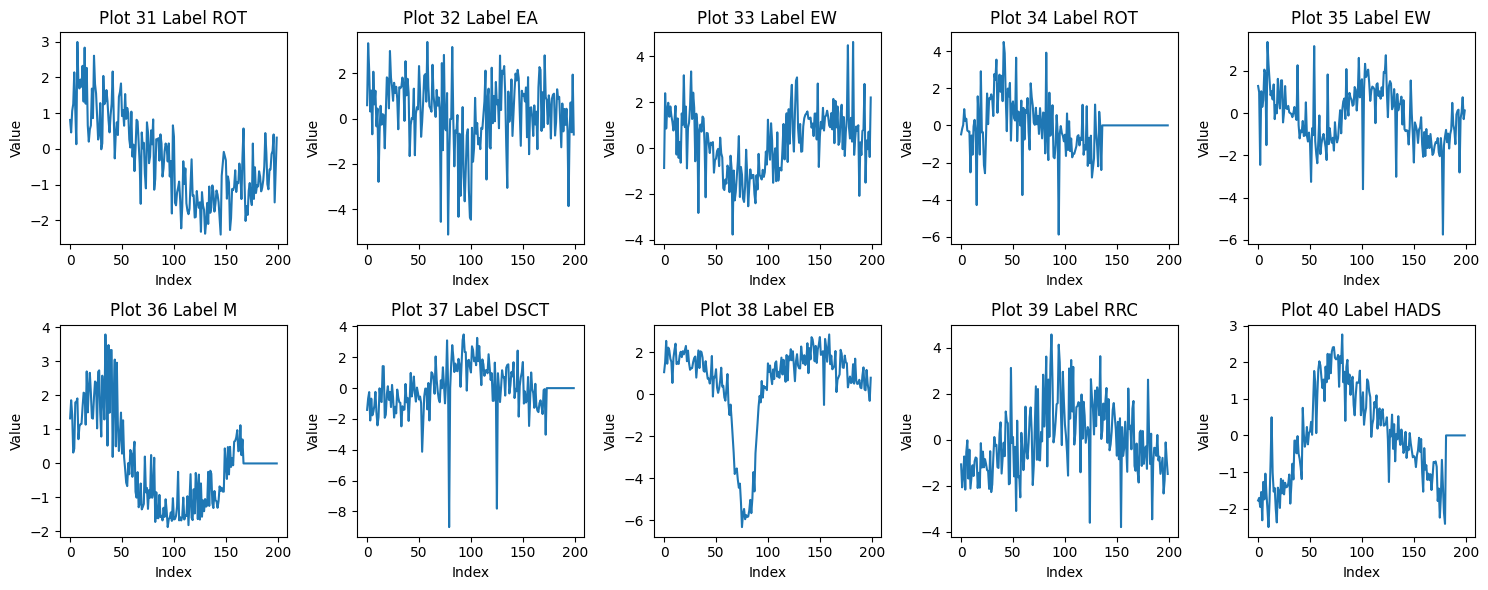

In [39]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images
n = 30

for i in range(n, n + 10):
    ax = axs[(i - n) // 5, i % 5]  # Determine the position of the subplot
    X, mask, y = train_dataset[i]
    ax.plot(X[:, 0])  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1} Label {train_dataset.id2target[y]}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

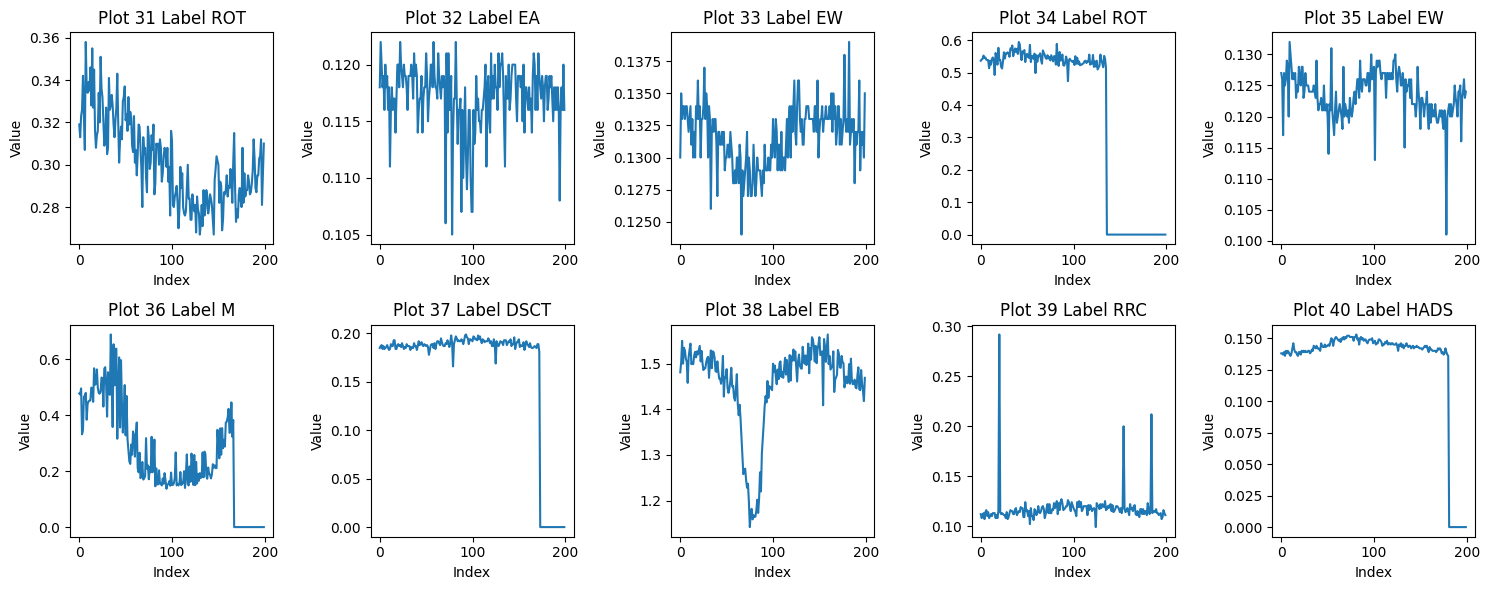

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images
n = 30

for i in range(n, n + 10):
    ax = axs[(i - n) // 5, i % 5]  # Determine the position of the subplot
    X, mask, y = train_dataset[i]
    ax.plot(X[:, 1])  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1} Label {train_dataset.id2target[y]}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

In [533]:
df

,target,period,name,id,band
0,RRC,0.418185,ASASSN-VJ171434.75+301729.6,EDR3 1333085560085564544,v
1,SR,46.014660,ASASSN-VJ174515.61-233254.0,EDR3 4068746631246255360,v
2,GCAS,284.777566,ASASSN-VJ005322.24-712047.1,EDR3 4689351160433257088,v
3,YSO,NaN,ASASSN-VJ085902.90+484609.5,EDR3 1015641228702925312,v
4,EA,1.036848,ASASSN-VJ055221.41-114544.9,EDR3 2998669067111288832,v
...,...,...,...,...,...
1054628,ROT,1.181500,ASASSN-V_J034319.56+862043.7,EDR3 574865021631225984,g
1054629,SR,145.000000,ASASSN-V_J033035.70+874143.0,EDR3 575940206563807488,g
1054630,EW,0.461403,ASASSN-V_J030004.71+864852.7,EDR3 574764759914002432,g
1054631,RRD,0.582628,ASASSN-V_J003522.69+875319.1,EDR3 575844033655835776,g


In [252]:
with open(os.path.join(data_root, 'g_band_lcs/ASASSN-V_J081525.82+840659.7.dat'), 'r') as file:
    content = file.read()

In [248]:
data_path = os.path.join(data_root, 'vardb_files/ASASSN-VJ171434.75+301729.6.dat')
lc1 = pd.read_csv(data_path, delim_whitespace=True, skiprows=2, names=['HJD', 'MAG', 'MAG_ERR', 'FLUX', 'FLUX_ERR'])

In [254]:
data_path = os.path.join(data_root, 'g_band_lcs/ASASSN-V_J081525.82+840659.7.dat')
lc2 = pd.read_csv(data_path, delim_whitespace=True, skiprows=2, 
                  names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'])

In [257]:
lc2

,HJD,camera,mag,mag_err,flux,flux_err,FWHM,IMAGE
0,2.458088e+06,bt,15.094,0.04211,3.416,0.13234,1.49,coadd_bt021552
1,2.458100e+06,bt,15.111,0.04260,3.364,0.13185,1.59,coadd_bt024315
2,2.458102e+06,bt,15.115,0.04272,3.350,0.13167,1.49,coadd_bt025240
3,2.458128e+06,bt,15.148,0.04370,3.252,0.13075,1.61,coadd_bt034805
4,2.458143e+06,bt,15.101,0.04231,3.393,0.13208,1.49,coadd_bt039431
...,...,...,...,...,...,...,...,...
356,2.459549e+06,bt,15.004,0.03963,3.711,0.13530,1.47,coadd_bt393895
357,2.459551e+06,bt,15.027,0.04024,3.635,0.13459,1.48,coadd_bt394773
358,2.459553e+06,bt,15.029,0.04030,3.627,0.13447,1.46,coadd_bt395612
359,2.459556e+06,bt,15.075,0.04157,3.477,0.13298,1.58,coadd_bt396595


In [267]:
df[df['period'].isna()]

,target,period,name,id,band
3,YSO,NaN,ASASSN-VJ085902.90+484609.5,EDR3 1015641228702925312,v
6,ROT:,NaN,ASASSN-VJ022330.33+555641.8,EDR3 457483737237930496,v
7,VAR,NaN,ASASSN-VJ183254.45-315431.5,EDR3 4046583981478280064,v
8,VAR,NaN,ASASSN-VJ103945.59-641818.4,EDR3 5239886047056506112,v
14,L,NaN,ASASSN-VJ174127.78-250709.4,EDR3 4067978377494174592,v
...,...,...,...,...,...
1053460,SR,NaN,ASASSN-V_J040821.90+721758.2,EDR3 501361191847081472,g
1053506,SR,NaN,ASASSN-V_J201230.59+735153.5,EDR3 2276381255846541824,g
1053565,L,NaN,ASASSN-V_J000355.30+763058.7,EDR3 539860690274357376,g
1053613,SR,NaN,ASASSN-V_J223413.56+765908.9,EDR3 2280718176384380032,g


In [278]:
lcs_v = ZipFile(v_folder)
lcs_g = tarfile.open(g_folder, 'r')

In [339]:
df.iloc[0]

target                            RRC
period                       0.418185
name      ASASSN-VJ171434.75+301729.6
id           EDR3 1333085560085564544
band                                v
Name: 0, dtype: object

In [340]:
csv = BytesIO()
data_path = 'vardb_files/ASASSN-VJ171434.75+301729.6.dat'

csv.write(lcs_v.read(data_path))
csv.seek(0)

lc1 = pd.read_csv(csv, delim_whitespace=True, skiprows=2, names=['HJD', 'MAG', 'MAG_ERR', 'FLUX', 'FLUX_ERR'])

In [341]:
lc = lc1[['HJD', 'FLUX', 'FLUX_ERR']].values

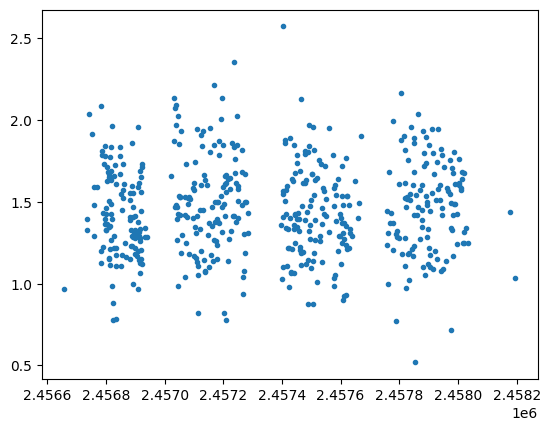

In [342]:
plt.plot(lc[:, 0], lc[:, 1], '.')

In [343]:
t, y, dy = lc[:, 0], lc[:, 1], lc[:, 2]
P_best = df.iloc[0]['period']

In [345]:
res = np.vstack(((t % P_best) / P_best, y, dy)).T

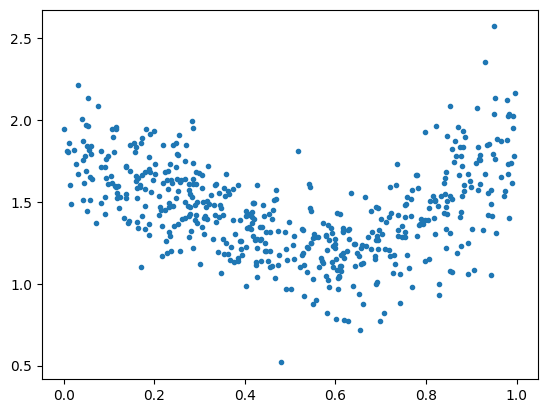

In [348]:
plt.plot(res[:, 0], res[:, 1], '.')

In [353]:
np.vstack(((t % P_best) / P_best, y, dy)).shape

(3, 523)

In [354]:
sorted_indices = np.argsort(lc[:, 0])
sorted_lc = lc[sorted_indices]

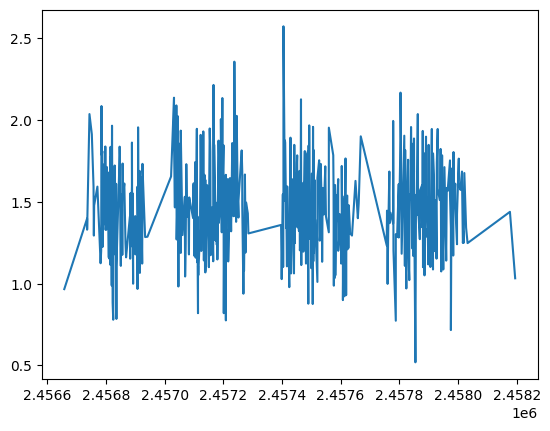

In [357]:
plt.plot(sorted_lc[:, 0], sorted_lc[:, 1])

In [360]:
sorted_indices = np.argsort(res[:, 0])
sorted_res = res[sorted_indices]

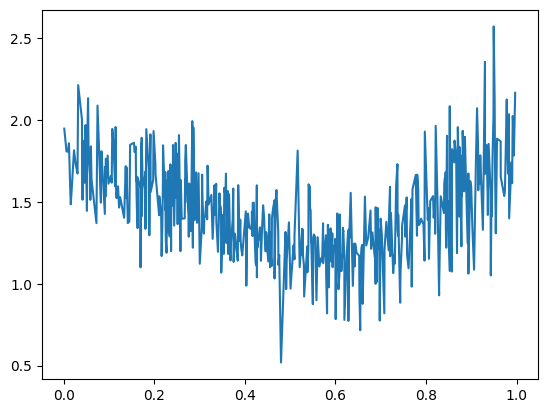

In [362]:
plt.plot(sorted_res[:, 0], sorted_res[:, 1])

In [ ]:
for file_name in tqdm(os.listdir(os.path.join(data_root, 'vardb_files'))):
    csv = BytesIO()
    data_path = f'vardb_files/{file_name}'
    
    csv.write(lcs_v.read(data_path))
    csv.seek(0)
    
    lc1 = pd.read_csv(csv, delim_whitespace=True, skiprows=2, names=['HJD', 'MAG', 'MAG_ERR', 'FLUX', 'FLUX_ERR'],
                      dtype={'HJD': float, 'MAG': float, 'MAG_ERR': float, 'FLUX': float, 'FLUX_ERR': float})

In [297]:
lock = FileLock('g_band_zip.lock')

In [527]:
lock = FileLock('g_band_zip.lock')
f = lcs_g.getmember('g_band_lcs/ASASSN-V_J081525.82+840659.7.dat')

with lock:
    lc2 = pd.read_csv(lcs_g.extractfile(f), delim_whitespace=True, skiprows=2, names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'])

print(lc2[['HJD', 'flux', 'flux_err']].values)

[[2.45808792e+06 3.41600000e+00 1.32340000e-01]
 [2.45809989e+06 3.36400000e+00 1.31850000e-01]
 [2.45810188e+06 3.35000000e+00 1.31670000e-01]
 ...
 [2.45955286e+06 3.62700000e+00 1.34470000e-01]
 [2.45955595e+06 3.47700000e+00 1.32980000e-01]
 [2.45956501e+06 3.64300000e+00 1.34700000e-01]]


In [528]:
lock = FileLock('g_band_zip.lock')
f = lcs_g.extractfile('g_band_lcs/ASASSN-V_J081525.82+840659.7.dat')

with lock:
    lc3 = pd.read_csv(f, delim_whitespace=True, skiprows=2, names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'])

print(lc3[['HJD', 'flux', 'flux_err']].values)

[[2.45808792e+06 3.41600000e+00 1.32340000e-01]
 [2.45809989e+06 3.36400000e+00 1.31850000e-01]
 [2.45810188e+06 3.35000000e+00 1.31670000e-01]
 ...
 [2.45955286e+06 3.62700000e+00 1.34470000e-01]
 [2.45955595e+06 3.47700000e+00 1.32980000e-01]
 [2.45956501e+06 3.64300000e+00 1.34700000e-01]]


In [529]:
lock = FileLock('g_band_zip.lock')
f = lcs_g.extractfile('g_band_lcs/ASASSN-V_J081525.82+840659.7.dat')
lc4 = pd.read_csv(f, delim_whitespace=True, skiprows=2, names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'])

print(lc4[['HJD', 'flux', 'flux_err']].values)

[[2.45808792e+06 3.41600000e+00 1.32340000e-01]
 [2.45809989e+06 3.36400000e+00 1.31850000e-01]
 [2.45810188e+06 3.35000000e+00 1.31670000e-01]
 ...
 [2.45955286e+06 3.62700000e+00 1.34470000e-01]
 [2.45955595e+06 3.47700000e+00 1.32980000e-01]
 [2.45956501e+06 3.64300000e+00 1.34700000e-01]]


In [523]:
f1 = lcs_g.extractfile('g_band_lcs/ASASSN-V_J081525.82+840659.7.dat')

In [525]:
with lock:
    lc3 = pd.read_csv(f1, delim_whitespace=True, skiprows=2, names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'])

In [526]:
lc3[['HJD', 'flux', 'flux_err']].values

array([[2.45808792e+06, 3.41600000e+00, 1.32340000e-01],
       [2.45809989e+06, 3.36400000e+00, 1.31850000e-01],
       [2.45810188e+06, 3.35000000e+00, 1.31670000e-01],
       ...,
       [2.45955286e+06, 3.62700000e+00, 1.34470000e-01],
       [2.45955595e+06, 3.47700000e+00, 1.32980000e-01],
       [2.45956501e+06, 3.64300000e+00, 1.34700000e-01]])

In [302]:
with lock:
    lc2 = pd.read_csv(lcs_g.extractfile(f), delim_whitespace=True, skiprows=2, names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'])

In [316]:
lc2[['HJD', 'flux', 'flux_err']].values

array([[2.45803288e+06, 2.09390000e+01, 4.41300000e-01],
       [2.45804396e+06, 2.22280000e+01, 4.77500000e-01],
       [2.45805290e+06, 2.25570000e+01, 4.87100000e-01],
       ...,
       [2.45954106e+06, 2.13130000e+01, 4.51660000e-01],
       [2.45954390e+06, 2.13640000e+01, 4.53000000e-01],
       [2.45954704e+06, 2.17620000e+01, 4.64160000e-01]])

In [311]:
for el in tqdm(df[df['band'] == 'g']['name']):
    f = lcs_g.getmember(f'g_band_lcs/{el}.dat')
    with lock:
        lc2 = pd.read_csv(lcs_g.extractfile(f), delim_whitespace=True, skiprows=2, names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'],
                          dtype={'HJD': float, 'camera': 'object', 'mag': 'object', 'mag_err': 'object', 'flux': float, 'flux_err': float, 'FWHM': 'object', 'IMAGE': 'object'})

lc2[['HJD', 'flux', 'flux_err']].values

  0%|▏                                               | 1307/378823 [01:23<6:40:36, 15.71it/s]


KeyboardInterrupt: 

In [369]:
lc.shape

(523, 3)

In [370]:
lc_padded = np.pad(lc, ((0, 27), (0, 0)), 'constant', constant_values=(0,))

In [378]:
mask = np.ones((200, 3))

In [490]:
unique_ids = df['id'].unique()

In [492]:
train_ids, temp_ids = train_test_split(unique_ids, test_size=0.2)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5)

In [495]:
np.intersect1d(train_ids, val_ids)

array([], dtype=object)

In [496]:
class VGDataset(Dataset):
    def __init__(self, data_root, vg_file, v_zip='asassnvarlc_vband_complete.zip', g_tar='g_band_lcs-001.tar', v_prefix='vardb_files', g_prefix='g_band_lcs', scales_file='scales.json',
                 seq_len=200, split='train', min_samples=5000, max_samples=50000, classes=None, random_seed=42, phased=True, periodic=True, verbose=True):
        self.data_root = data_root
        self.df = pd.read_csv(os.path.join(data_root, vg_file))
        self.reader_v = ZipFile(os.path.join(data_root, v_zip))
        self.reader_g = tarfile.open(os.path.join(data_root, g_tar), 'r')
        self.v_prefix = v_prefix
        self.g_prefix = g_prefix
        self.lock = FileLock('g_band_zip.lock')

        with open(os.path.join(data_root, scales_file)) as f:
            self.scales = json.load(f)

        self.seq_len = seq_len
        self.split = split
        self.min_samples = min_samples
        self.max_samples = max_samples
        self.classes = classes
        self.phased = phased
        self.periodic = periodic
        self.verbose = verbose

        self.random_seed = random_seed
        np.random.seed(random_seed)

        self._filter_classes()
        self._filter_periodic()
        self._limit_samples()
        self._split()

        self.id2target = {i: x for i, x in enumerate(self.df['target'].unique())}
        self.target2id = {v: k for k, v in self.id2target.items()}

    def _split(self):        
        unique_ids = self.df['id'].unique()
        train_ids, temp_ids = train_test_split(unique_ids, test_size=0.2, random_state=self.random_seed)
        val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=self.random_seed)
        
        if self.split == 'train':
            self.df = self.df[self.df['id'].isin(train_ids)]
        elif self.split == 'val':
            self.df = self.df[self.df['id'].isin(val_ids)]
        elif self.split == 'test':
            self.df = self.df[self.df['id'].isin(test_ids)]
        else:
            print('Split is not train, val, or test. Keeping the whole dataset')

        if self.verbose:
            print(f'{self.split} split is selected: {len(self.df)} objects left.')

    def _filter_classes(self):
        if self.classes:
            if self.verbose:
                print(f'Leaving only classes: {self.classes}... ', end='')
                        
            self.df = self.df[self.df['target'].isin(self.classes)]

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _filter_periodic(self):
        if self.periodic:
            if self.verbose:
                print(f'Removing objects without periods... ', end='')

            self.df = self.df[~self.df['period'].isna()]
            
            if self.verbose:
                print(f'{len(self.df)} objects left.')
            
    def _limit_samples(self):
        if self.max_samples or self.min_samples:
            if self.verbose:
                print(f'Removing objects that have more than {self.max_samples} or less than {self.min_samples} samples... ', end='')
                
            value_counts = self.df['target'].value_counts()

            if self.min_samples:
                classes_to_remove = value_counts[value_counts < self.min_samples].index
                self.df = self.df[~self.df['target'].isin(classes_to_remove)]
                            
            if self.max_samples:
                classes_to_limit = value_counts[value_counts > self.max_samples].index
                for class_type in classes_to_limit:
                    class_indices = self.df[self.df['target'] == class_type].index
                    indices_to_keep = np.random.choice(class_indices, size=self.max_samples, replace=False)
                    self.df = self.df.drop(index=set(class_indices) - set(indices_to_keep))

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def get_vlc(self, file_name):
        csv = BytesIO()
        data_path = f'{self.v_prefix}/{file_name}.dat'
        
        csv.write(self.reader_v.read(data_path))
        csv.seek(0)
        
        lc = pd.read_csv(csv, delim_whitespace=True, skiprows=2, names=['HJD', 'MAG', 'MAG_ERR', 'FLUX', 'FLUX_ERR'],
                         dtype={'HJD': float, 'MAG': float, 'MAG_ERR': float, 'FLUX': float, 'FLUX_ERR': float}) 
        
        return lc[['HJD', 'FLUX', 'FLUX_ERR']].values

    def get_glc(self, file_name):
        f = self.reader_g.getmember(f'{self.g_prefix}/{file_name}.dat')
        
        with self.lock:
            lc = pd.read_csv(self.reader_g.extractfile(f), delim_whitespace=True, skiprows=2, names=['HJD', 'camera', 'mag', 'mag_err', 'flux', 'flux_err', 'FWHM', 'IMAGE'],
                             dtype={'HJD': float, 'camera': 'object', 'mag': 'object', 'mag_err': 'object', 'flux': float, 'flux_err': float, 'FWHM': 'object', 'IMAGE': 'object'})

        return lc[['HJD', 'flux', 'flux_err']].values
        
    def preprocess(self, X, period, band):
        # phase
        if self.phased:
            X = np.vstack(((X[:, 0] % period) / period, X[:, 1], X[:, 2])).T

        # sort based on HJD
        sorted_indices = np.argsort(X[:, 0])
        X = X[sorted_indices]

        # normalize
        mean, std = self.scales[band]['mean'], self.scales[band]['std']
        X[:, 1] = (X[:, 1] - mean) / std
        X[:, 2] = X[:, 2] / std

        # trim/pad and create mask
        mask = np.ones((self.seq_len, 3))
        
        if X.shape[0] > self.seq_len:
            X = X[:self.seq_len, :]
        else:
            mask[X.shape[0]:, :] = 0
            X = np.pad(X, ((0, self.seq_len - X.shape[0]), (0, 0)), 'constant', constant_values=(0,))

        return X, mask
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        el = self.df.iloc[idx]

        X = self.get_vlc(el['name']) if el['band'] == 'v' else self.get_glc(el['name'])
        X, mask = self.preprocess(X, el['period'], el['band'])
        y = self.target2id[el['target']]

        return X, mask, y

In [468]:
data_root = '/home/mariia/AstroML/data/asassn'
vg_file = 'vg_combined.csv'

train_dataset = VGDataset(data_root, vg_file, classes=None, split='train')

Removing objects without periods... 848300 objects left.
Removing objects that have more than 50000 or less than 5000 samples... 368345 objects left.
train split is selected: 294798 objects left.


In [471]:
X, mask, y = train_dataset[1]

In [475]:
X.shape, mask.shape, y

((200, 3), (200, 3), 1)

In [479]:
train_dataloader = DataLoader(train_dataset, batch_size=512)

In [481]:
for i in tqdm(range(10)):
    batch = next(iter(train_dataloader))

100%|████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]


In [483]:
old_train_dataloader = DataLoader(ds_train, batch_size=512, collate_fn=no_spectra_collate_fn)

In [484]:
for i in tqdm(range(10)):
    batch = next(iter(old_train_dataloader))

100%|████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.13s/it]


In [497]:
old_batch = next(iter(old_train_dataloader))

In [499]:
b, m = old_batch

In [500]:
X, y = b
X_m, y_m = m

In [501]:
X.shape, X_m.shape

(torch.Size([512, 1, 3, 135915]), torch.Size([512, 1, 3, 135915]))

In [502]:
X, mask, y = next(iter(train_dataloader))

In [503]:
X.shape, mask.shape

(torch.Size([512, 200, 3]), torch.Size([512, 200, 3]))

In [324]:
res = {i: x for i, x in enumerate(df['target'].unique())}

In [122]:
def preprocess_batch(batch, masks):
    lcs, classes = batch
    lcs_mask, classes_mask = masks

    # shape now [128, 1, 3, 759], make [128, 3, 759] 
    X = lcs[:, 0, :, :]
    
    # change axises, shape now [128, 3, 759], make [128, 759, 3]
    X = X.transpose(1, 2)
    
    # since mask is the same for time flux and flux err we can make it 2D
    mask = lcs_mask[:, 0, 0, :]

    # context length 200, crop X and MASK if longer, pad if shorter
    if X.shape[1] < context_length:
        X_padding = (0, 0, 0, context_length - X.shape[1], 0, 0)
        mask_padding = (0, context_length - X.shape[1])
        X = F.pad(X, X_padding)
        mask = F.pad(mask, mask_padding, value=True)
    else:
        X = X[:, :context_length, :]
        mask = mask[:, :context_length]

    # the last dimention is (time, flux, flux_err), sort it based on time
    sort_indices = torch.argsort(X[:, :, 0], dim=1)
    sorted_X = torch.zeros_like(X)
    
    for i in range(X.shape[0]):
        sorted_X[i] = X[i, sort_indices[i]]
    
    # rearange indexes for masks as well
    sorted_mask = torch.zeros_like(mask)
    
    for i in range(mask.shape[0]):
        sorted_mask[i] = mask[i, sort_indices[i]]

    # mask should be 1 for values that are observed and 0 for values that are missing
    sorted_mask = 1 - sorted_mask.int()

    # read scales
    with open('scales.json', 'r') as f:
        scales = json.load(f)
        mean, std = scales['v']['mean'], scales['v']['std']

    # scale X
    sorted_X[:, :, 1] = (sorted_X[:, :, 1] - mean) / std
    sorted_X[:, :, 2] = sorted_X[:, :, 2] / std

    # reshape classes to be 1D vector and convert from float to int
    classes = classes[:, 0]
    classes = classes.long()
    
    return sorted_X, sorted_mask, classes

In [109]:
datapath = Path('../data/asassn')
ds_train = ASASSNVarStarDataset(datapath, mode='train', verbose=True, only_periodic=True, recalc_period=False, 
                                prime=True, use_bands=['v'], only_sources_with_spectra=False, return_phased=True, 
                                fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Removing duplicates for v band... Left with 675811. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 459022. done.
Removed non-periodic sources. Now 458988 sources.
Total: 458988, Train: 367190, Val: 45898, Test: 45900
Priming tarballs by doing initial scan... done.


In [126]:
context_length = 200
no_spectra_data_keys = ['lcs', 'classes']
no_spectra_collate_fn = partial(collate_fn, data_keys=no_spectra_data_keys, fill_value=0)

train_dataloader = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=0, 
                              collate_fn=no_spectra_collate_fn)

In [127]:
batch, batch_mask = next(iter(train_dataloader))

In [128]:
X, mask, y = preprocess_batch(batch, batch_mask)

In [ ]:
0.5 -flux

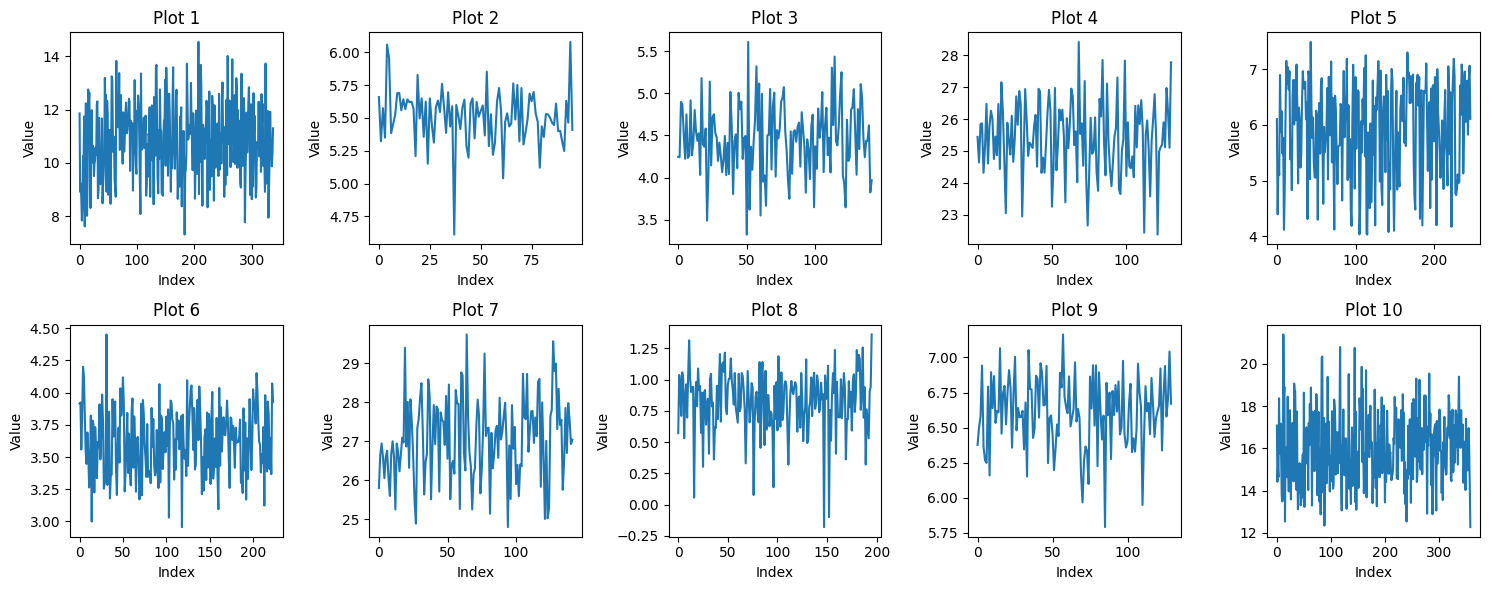

In [167]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(ds_train[i]['lcs'][0][0][:, 1])  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

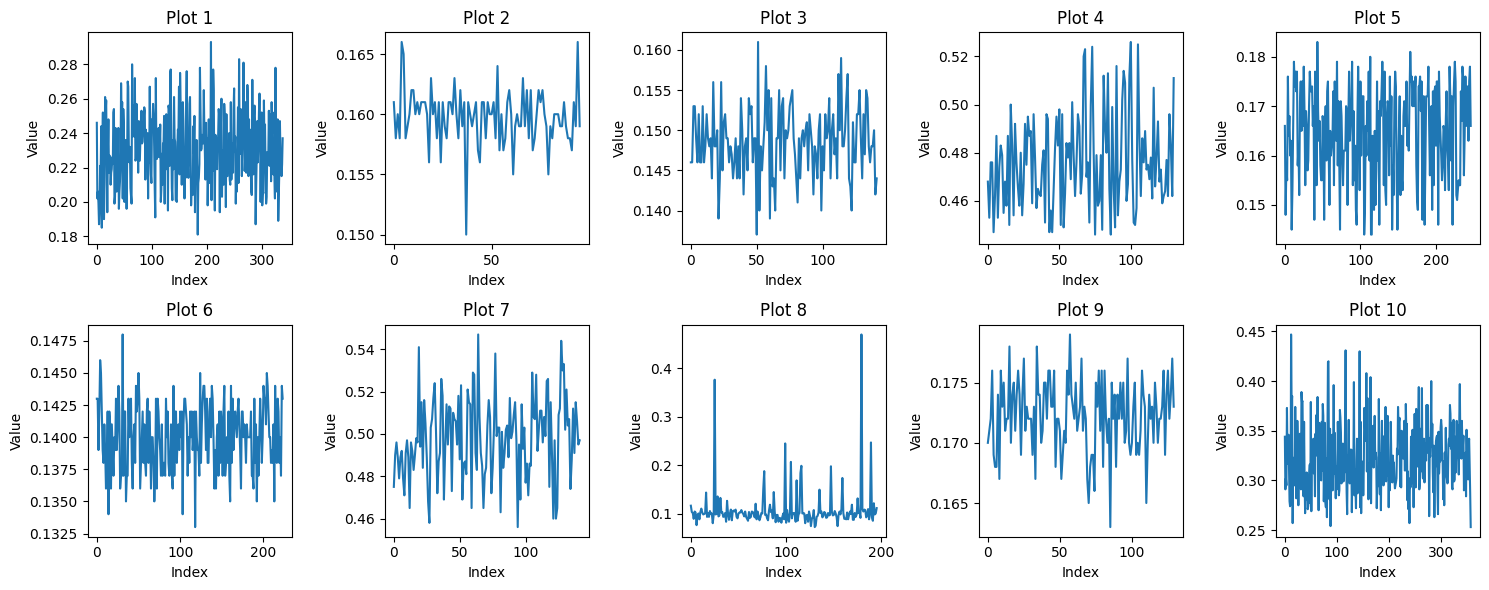

In [158]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(ds_train[i]['lcs'][0][0][:, 2])  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Valaue')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

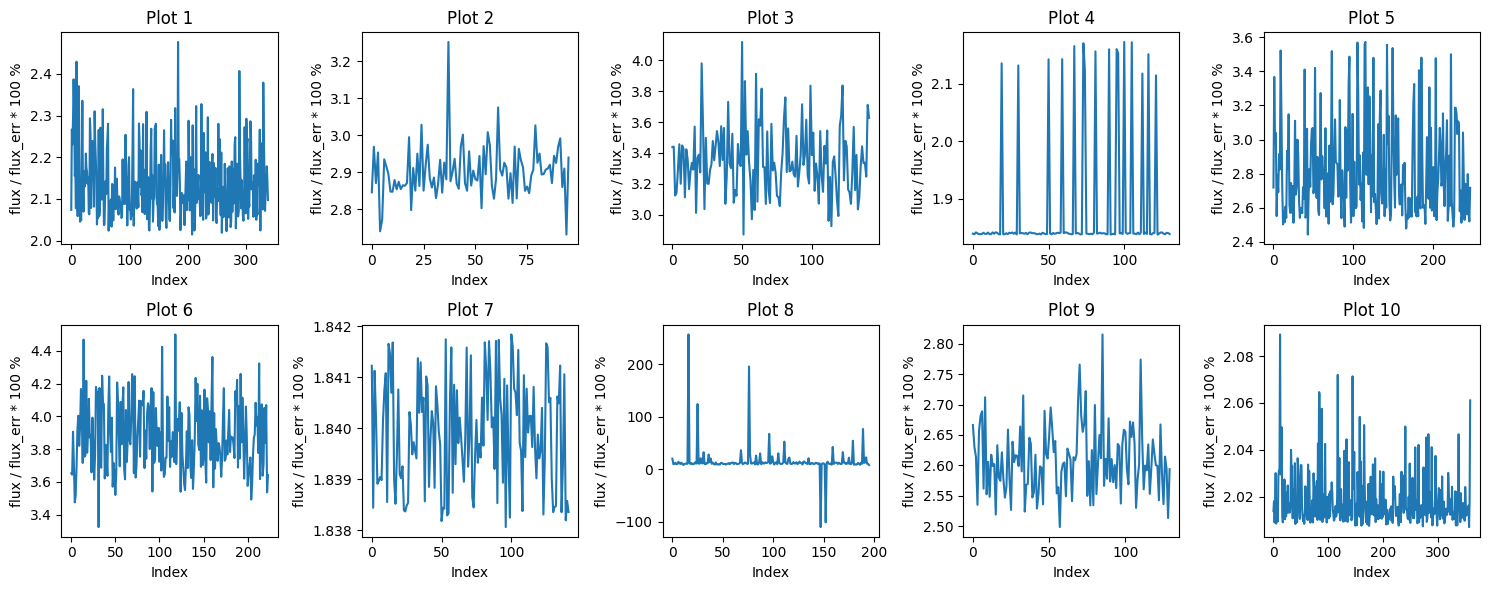

In [165]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(ds_train[i]['lcs'][0][0][:, 2] / ds_train[i]['lcs'][0][0][:, 1] * 100)  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('flux / flux_err * 100 %')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

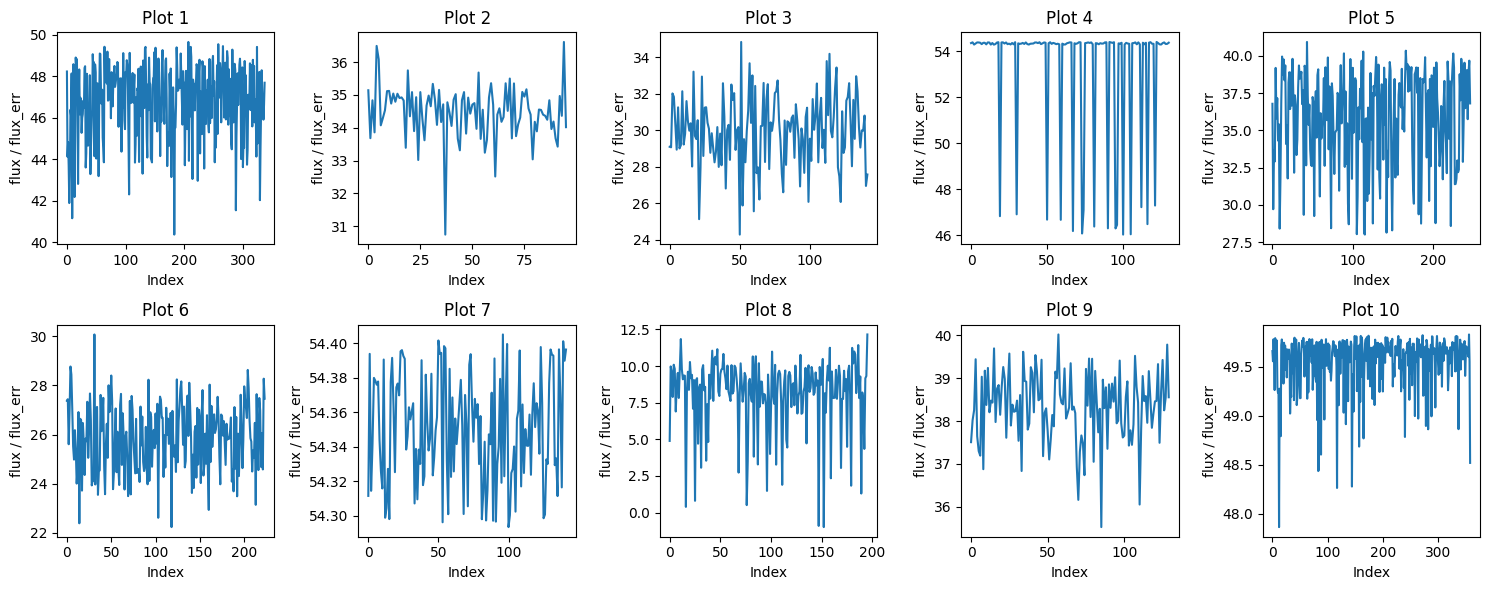

In [364]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(ds_train[i]['lcs'][0][0][:, 1] / ds_train[i]['lcs'][0][0][:, 2])  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('flux / flux_err')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

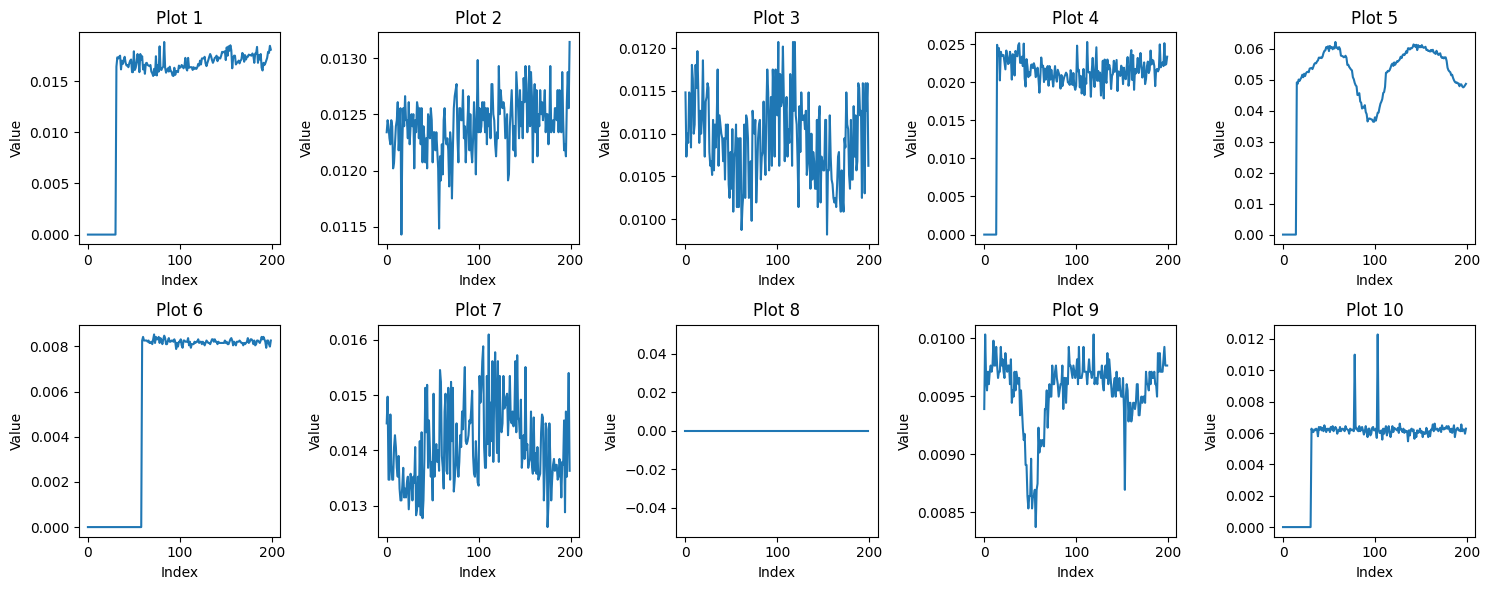

In [152]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(X[i, :, 2].numpy())  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

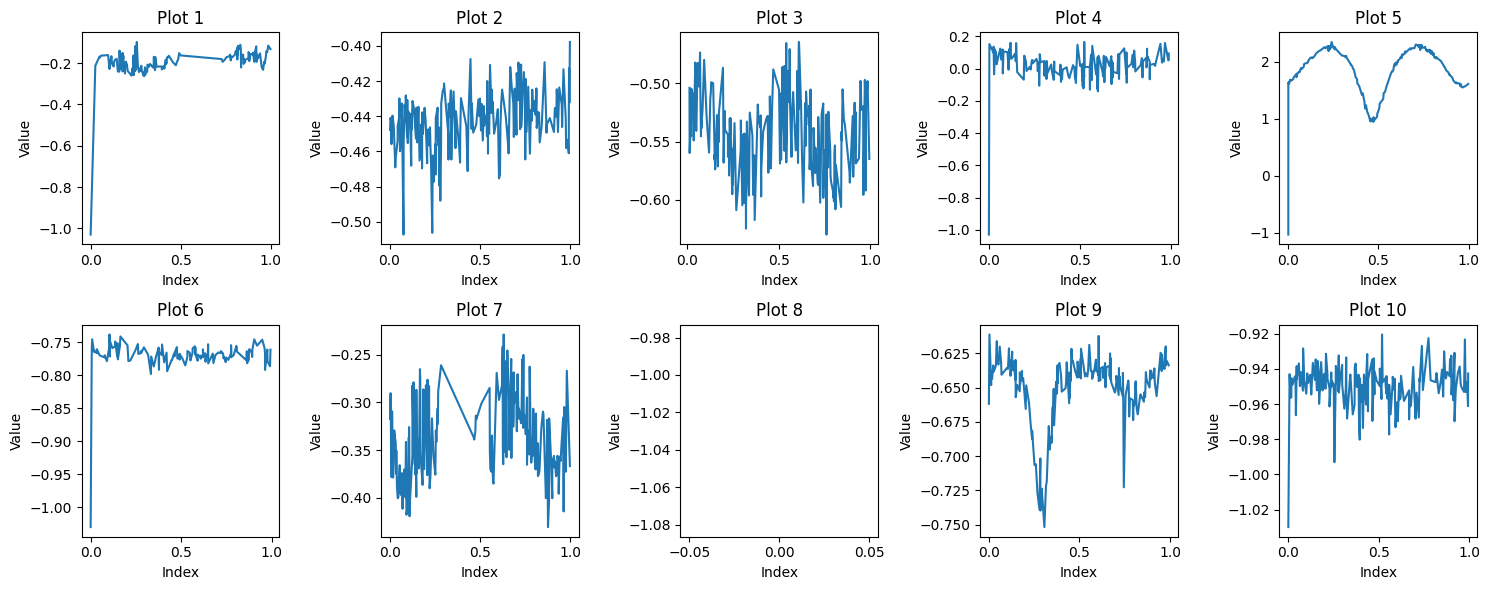

In [169]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(X[i, :, 0].numpy(), X[i, :, 1].numpy())  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

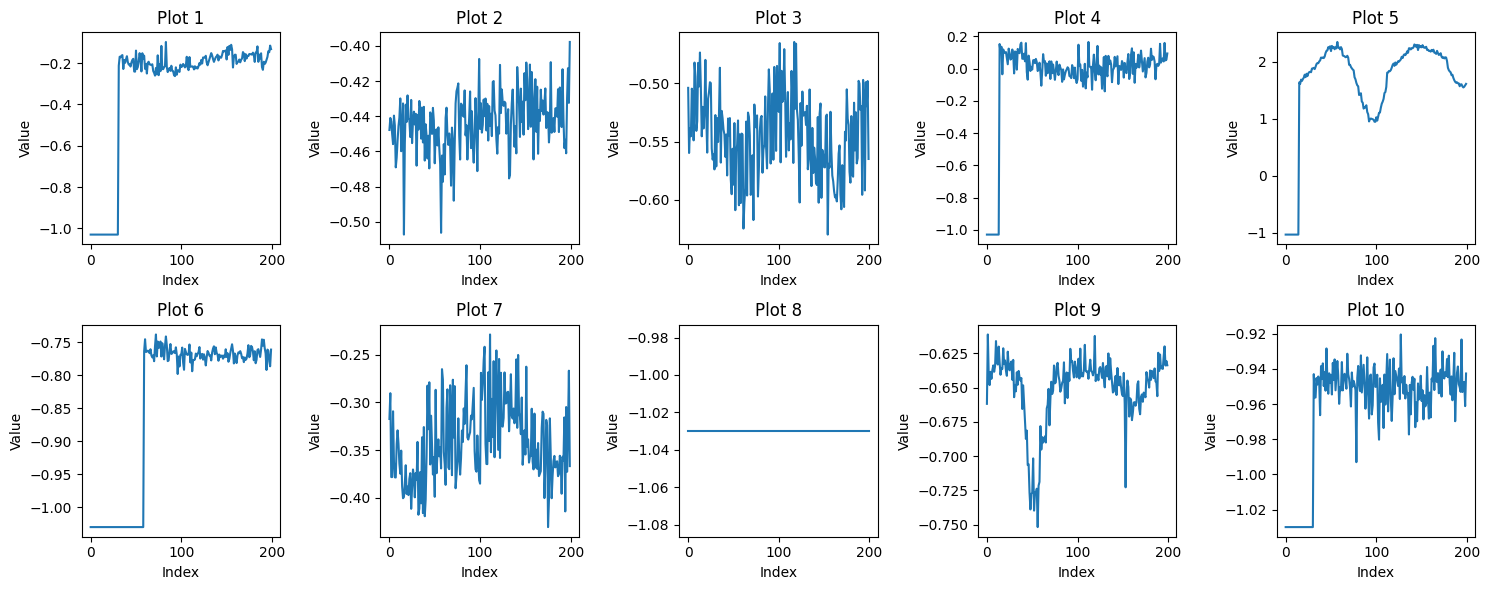

In [170]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(X[i, :, 1].numpy())  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

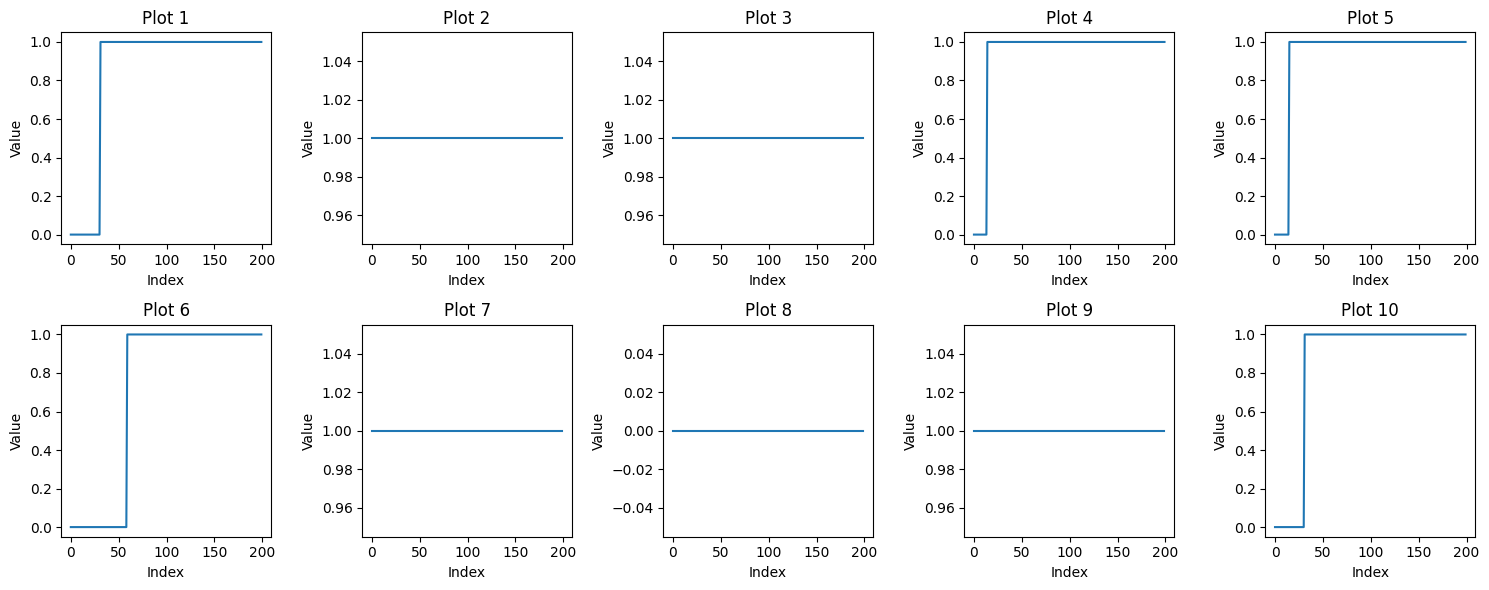

In [144]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(mask[i, :].numpy())  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

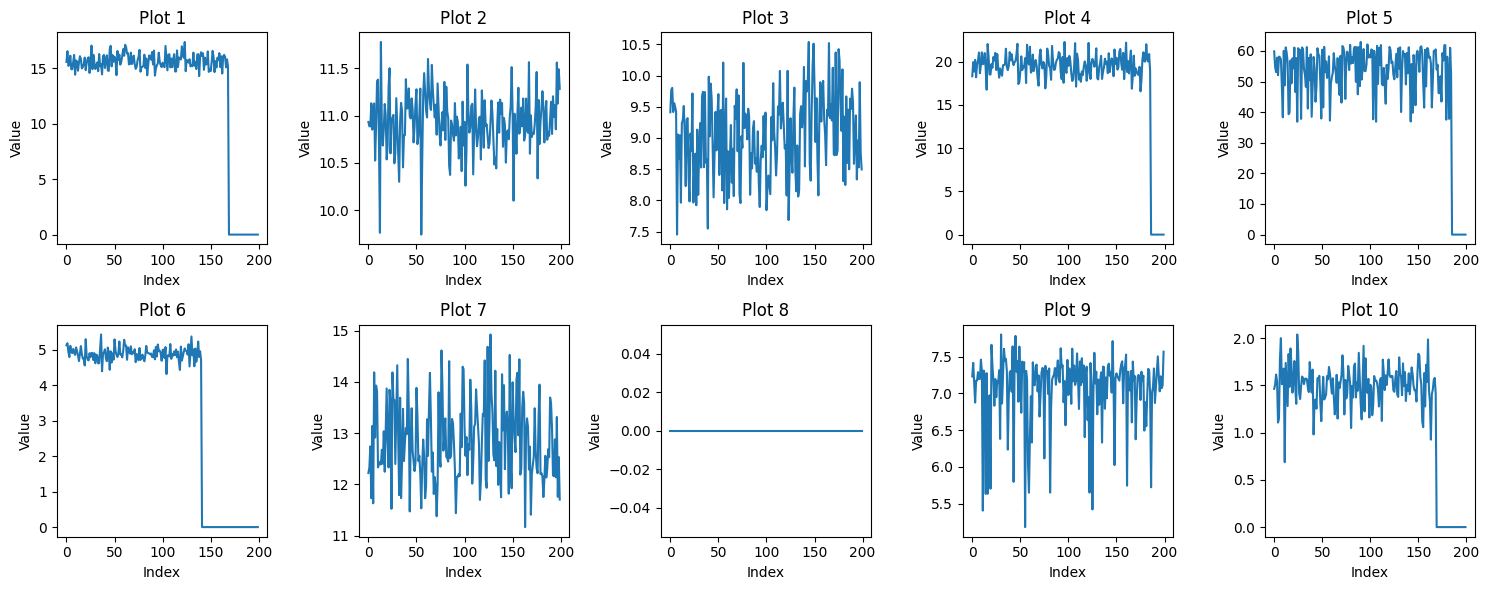

In [141]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(batch[0][i, 0, 1, :200].numpy())  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

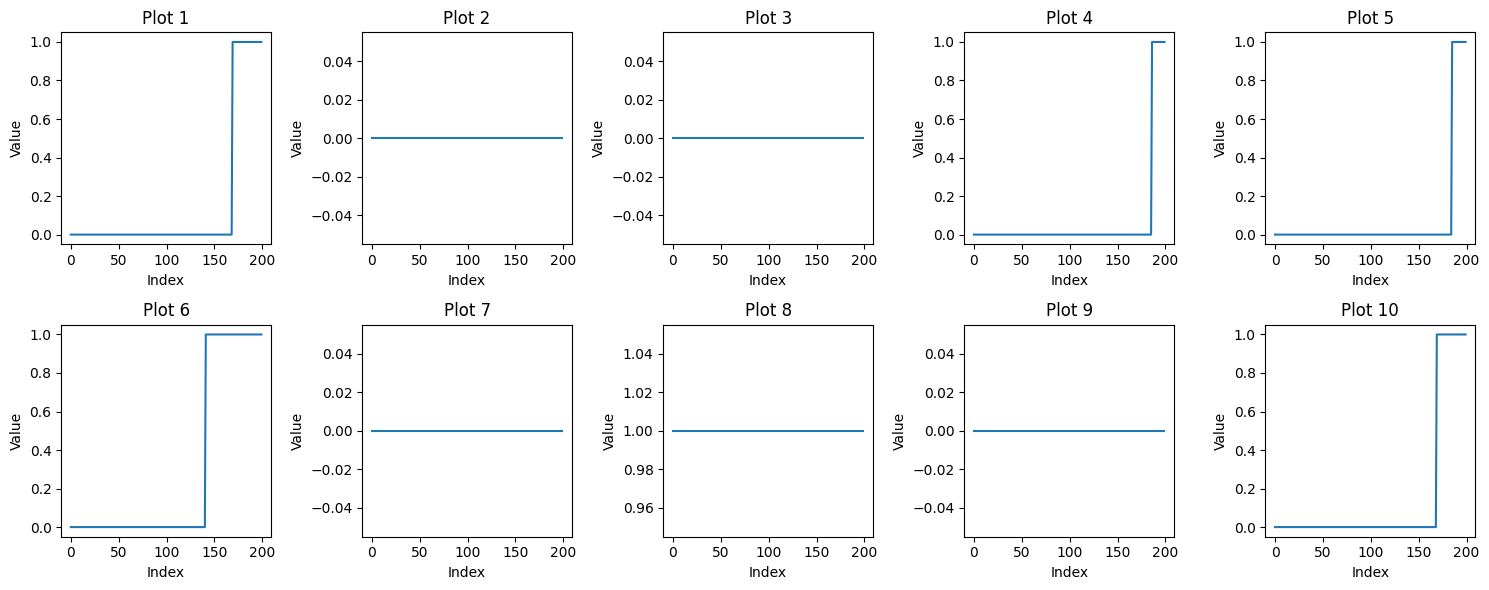

In [151]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns to plot 10 images

for i in range(10):
    ax = axs[i // 5, i % 5]  # Determine the position of the subplot
    ax.plot(batch_mask[0][i, 0, 1, :200].numpy())  # Plot the second column of the i-th tensor
    ax.set_title(f'Plot {i+1}')  # Optional: Set a title for each subplot
    ax.set_xlabel('Index')  # Optional: Set x-axis label
    ax.set_ylabel('Value')  # Optional: Set y-axis label

plt.tight_layout()
plt.show()

In [15]:
for i in tqdm(range(5000)):
    el = ds_train[i]

100%|████████████████████████████████████████████████████| 5000/5000 [01:28<00:00, 56.63it/s]


In [16]:
for i in tqdm(range(10)):
    el = next(iter(train_dataloader))

100%|████████████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.03s/it]


In [85]:
batch = [ds_train[i] for i in range(500)]

In [100]:
fill_value = 0
lcs = [torch.tensor(el['lcs'][0][0].astype(float)).unsqueeze(-1) for el in batch]

In [101]:
res = torch.nn.utils.rnn.pad_sequence(lcs, padding_value=0)
res.shape

torch.Size([135915, 500, 3, 1])

In [104]:
# return a tensor like batch_size, lcs/spectrum_number, [nu, flux, fluxerr], value
kb = torch.permute(res, (1, 3, 2, 0))

In [105]:
kb.shape

torch.Size([500, 1, 3, 135915])

In [77]:
b = next(iter(train_dataloader))

In [80]:
(x, y), (x_mask, y_mask) = b

In [82]:
x.shape

torch.Size([512, 1, 3, 253221])

In [27]:
from torch.nn.utils.rnn import pad_sequence
a = torch.ones(25, 300)
b = torch.ones(22, 300)
c = torch.ones(15, 300)
pad_sequence([a, b, c]).size()

torch.Size([25, 3, 300])

In [ ]:
def collate_fn_lcs(batch, fill_value=0):
    key_batch = [torch.Tensor(t[k]) for t in batch]
    kb = torch.nn.utils.rnn.pad_sequence(
        key_batch, batch_first=True, padding_value=fill_value
    ).squeeze(1)

In [ ]:
def collate_fn(
    batch, data_keys=["lcs", "metadata", "spectra", "classes"], fill_value=-9999
):
    """
    return a list of tensors with data and masks, for this batch. Makes the
    smallest possible tensors given the maximum size of each element in the batch.

    See https://pytorch.org/docs/stable/data.html#dataloader-collate-fn

    Parameters:
    -----------
    batch: list of dicts
        each dict is a single object
    data_keys: list of strings
        which keys to return
    fill_value: float
        value to use for missing data

    Returns:
    --------
    data: list of tensors
        the data for each key
    masks: list of tensors
        the masks for each key
    """
    data = []
    masks = []
    for k in data_keys:
        if k in ["metadata", "classes"]:
            key_batch = [torch.Tensor(t[k]) for t in batch]
            kb = torch.nn.utils.rnn.pad_sequence(
                key_batch, batch_first=True, padding_value=fill_value
            ).squeeze(1)

        if k in ["spectra", "lcs"]:
            spec = []
            max_spec = 200
            book = []
            for on, obj in enumerate(batch):
                obj_spec = obj[k][0]
                s = []
                ls = []
                for i in range(len(obj_spec)):
                    shape = list(obj_spec[i].shape)
                    # check for possible empty data vector
                    if shape[0] == 0:
                        shape[0] += 1
                        v = fill_value * torch.ones(shape)
                    else:
                        v = obj_spec[i]
                    s.append(torch.Tensor(v))
                    ls.append(s[-1].shape)

                if len(obj_spec) > 0:
                    last_shape = s[-1].shape
                else:
                    last_shape = (1, 1)
                    book.append((on, last_shape))

                # TODO Fix i outside of loop
                for j in range(i + 1, max_spec):
                    s.append(fill_value * torch.ones(last_shape))
                    ls.append(s[-1].shape)

                spec.append(
                    torch.nn.utils.rnn.pad_sequence(s, padding_value=fill_value)
                )

            try:
                max_shape = tuple(np.max(np.array([s.shape for s in spec]), axis=0))
            except Exception as err:
                raise err from None

            for i, s in enumerate(spec):
                if s.shape[0] <= 1:
                    book.append(("here", i, s.shape))
                    spec[i] = fill_value * torch.ones(max_shape)
            try:
                kb = torch.nn.utils.rnn.pad_sequence(spec, padding_value=fill_value)
            except Exception as err:
                for i, ss in enumerate(spec):
                    print(i, ss.shape, type(ss))
                raise err from None

            # return a tensor like batch_size, lcs/spectrum_number, [nu, flux, fluxerr],
            # value
            kb = torch.permute(kb, (1, 2, 3, 0))

        # make a mask and fill in.
        isnan = torch.isnan(kb)
        key_mask = torch.where(kb == fill_value, True, False) | isnan
        kb[key_mask] = fill_value
        data.append(kb)
        masks.append(key_mask)

    return data, masks